# MiniGoogLeNet
This model is specifically for MNIST, where the input dimension of the greyscale image is $1 \times 28 \times 28$.

The model below takes $N \times 32 \times 32$ as the input, where $N$ is the number of input channels.

Huge reference and inspiration from:
https://github.com/meng1994412/GoogLeNet_from_scratch/blob/master/pipeline/nn/conv/minigooglenet.py

The implementation of the above link is in tensorflow. I translated it into pytorch.



The overall structure of MiniGoogLeNet:
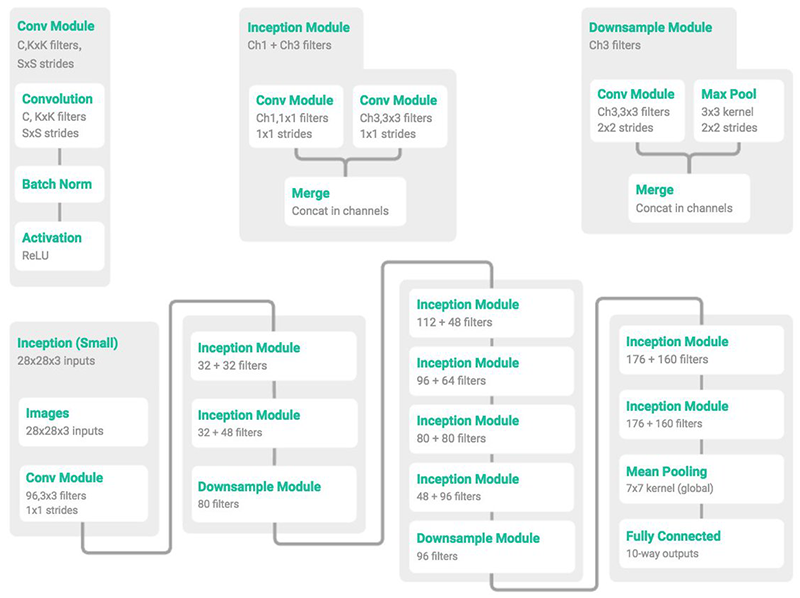


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# ConvModule: a convolutional module in the above picture, consists a 2d convolutional layer, a 2d batchnorm layer, and a ReLU activation.
class ConvModule(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size, stride, padding='same'):
    super(ConvModule, self).__init__()
    self.conv2d = nn.Conv2d(
        in_channels, out_channels, kernel_size, stride=stride, padding=padding)
    
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.conv2d(x)
    x = self.batchnorm(x)
    x = self.relu(x)

    return x

# InceptionModule: a inception module in the above picture, consists a convolution module with 1x1 filter, 
# a convolution module with 3x3 filter, then concatenate these two outputs.
class InceptionModule(nn.Module):
  def __init__(self, in_channels, ch1x1, ch3x3):
    super(InceptionModule, self).__init__()

    self.conv1x1 = ConvModule(in_channels, ch1x1, (1, 1), 1)
    self.conv3x3 = ConvModule(in_channels, ch3x3, (3, 3), 1)

  def forward(self, x):
    out1 = self.conv1x1(x)
    out2 = self.conv3x3(x)
    x = torch.cat((out1, out2), 1)
    return x

# DownsampleModule: a downsample module in the above picture, consists a convolution module with 3x3 filter,
# a 2d maxpool layer, then concatenate these two outputs.
class DownsampleModule(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DownsampleModule, self).__init__()

    self.conv3x3 = ConvModule(in_channels, out_channels, (3, 3), (2, 2), padding='valid')
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

  def forward(self, x):
    out1 = self.conv3x3(x)
    out2 = self.maxpool(x)

    #return out1
    x = torch.cat((out1, out2), 1)

    return x
    

# MiniGoogLeNet: the MiniGoogLeNet model. Input: input_channels * 32 * 32. 
# When input_channels is 1, the input is a grayscale image. When input_channels is 3, the input is a RGB image.
# Output: a tensor with the shape of [-1, classes], where classes it the number of classes.

class MiniGoogLeNet(nn.Module):
  def __init__(self, classes, input_channels):
    super(MiniGoogLeNet, self).__init__()

    self.conv1 = ConvModule(input_channels, 96, kernel_size=(3, 3), stride=1) # Change 1 to 3 if you want to deal with RGB image
    self.inception1 = InceptionModule(96, 32, 32)
    self.inception2 = InceptionModule(32+32, 32, 48)
    self.downsample1 = DownsampleModule(32+48, 80)

    self.inception3 = InceptionModule(80+80, 112, 48)
    self.inception4 = InceptionModule(112+48, 96, 64)
    self.inception5 = InceptionModule(96+64, 80, 80)
    self.inception6 = InceptionModule(80+80, 48, 96)
    self.downsample2 = DownsampleModule(48+96, 96)

    self.inception7 = InceptionModule(96+96, 176, 160)
    self.inception8 = InceptionModule(176+160, 176, 160)
    self.avgpool2d = nn.AvgPool2d(kernel_size=7)
    self.dropout = nn.Dropout2d(0.5)

    self.fc = nn.Linear(240, classes)
    self.softmax = nn.Softmax(dim=-1)





  def forward(self, x):
    x = self.conv1(x)
    #print(x.shape)
    x = self.inception1(x)
    x = self.inception2(x)
    x = self.downsample1(x)

    x = self.inception3(x)
    x = self.inception4(x)
    x = self.inception5(x)
    x = self.inception6(x)
    x = self.downsample2(x)

    x = self.avgpool2d(x)
    x = self.dropout(x)

    x = torch.flatten(x, 1)
    x = self.fc(x)
    x = self.softmax(x)

    return x

  

In [2]:
from torchsummary import summary
showmodel = MiniGoogLeNet(10, 1).to("cuda:0" if torch.cuda.is_available() else "cpu")
summary(showmodel, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]             960
       BatchNorm2d-2           [-1, 96, 32, 32]             192
              ReLU-3           [-1, 96, 32, 32]               0
        ConvModule-4           [-1, 96, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           3,104
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
        ConvModule-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]          27,680
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
       ConvModule-12           [-1, 32, 32, 32]               0
  InceptionModule-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 32,

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5/5 [03:11<00:00, 38.25s/it]


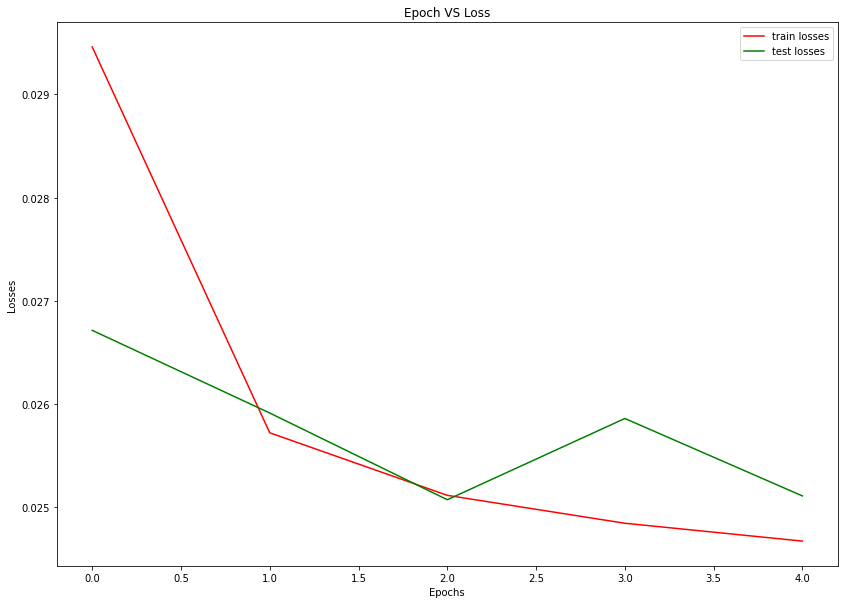

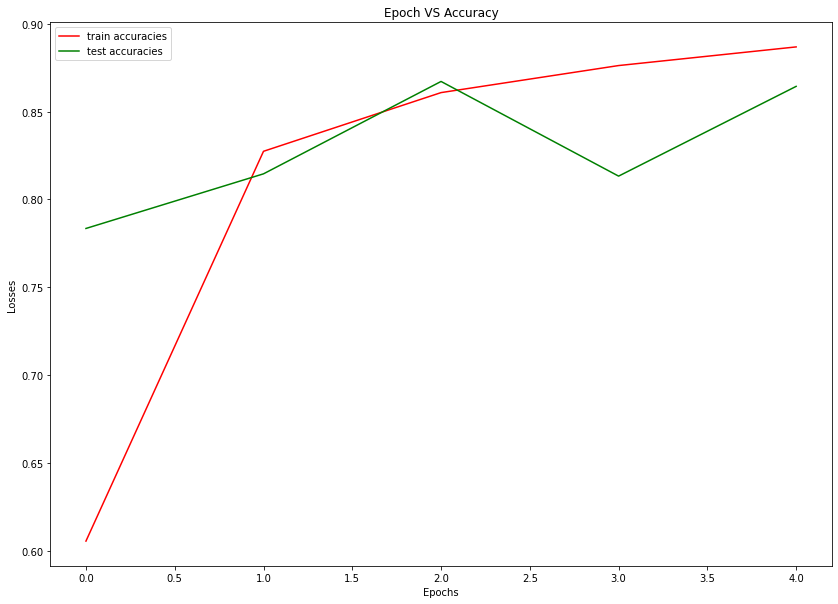

In [ ]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm


def train(model, criterion, optimizer, scheduler, dataloader, device):
  model.train()
  train_loss = 0
  total = 0
  correct = 0

  for image, label in dataloader:
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)

    train_loss += loss.item()
    total += label.size(0)

    pred = torch.max(output.data, 1)[1]
    correct += (pred == label).sum().item()

    loss.backward()
    optimizer.step()
    scheduler.step()

  accuracy = correct/total

  return train_loss/total, accuracy

def test(model, criterion, dataloader, device):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        
        pred = model(images)
        loss = criterion(pred, labels)
        test_loss += loss.item()
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

  accuracy = correct / total
  return test_loss/total, accuracy

train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))


train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MiniGoogLeNet(10, 1)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=10000, gamma=0.85)
epochs = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for i in tqdm(range(epochs)):
  train_loss, train_accuracy = train(model, criterion, optimizer, scheduler, train_loader, device)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  val_loss, val_accuracy = test(model, criterion, test_loader, device)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

plt.figure(figsize=(14, 10))
plt.plot(range(epochs), train_losses, c='r', label='train losses')
plt.plot(range(epochs), val_losses, c='g', label='test losses')
plt.title("Epoch VS Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

plt.figure(figsize=(14, 10))
plt.plot(range(epochs), train_accuracies, c='r', label='train accuracies')
plt.plot(range(epochs), val_accuracies, c='g', label='test accuracies')
plt.title("Epoch VS Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()



# RGB
Now, we try with RGB. Remember, we need to do a slight change when we call the MiniGoogLeNet model

# Cifar 10
Next, we try with cifar 10 with 5 epochs.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 5/5 [02:48<00:00, 33.68s/it]


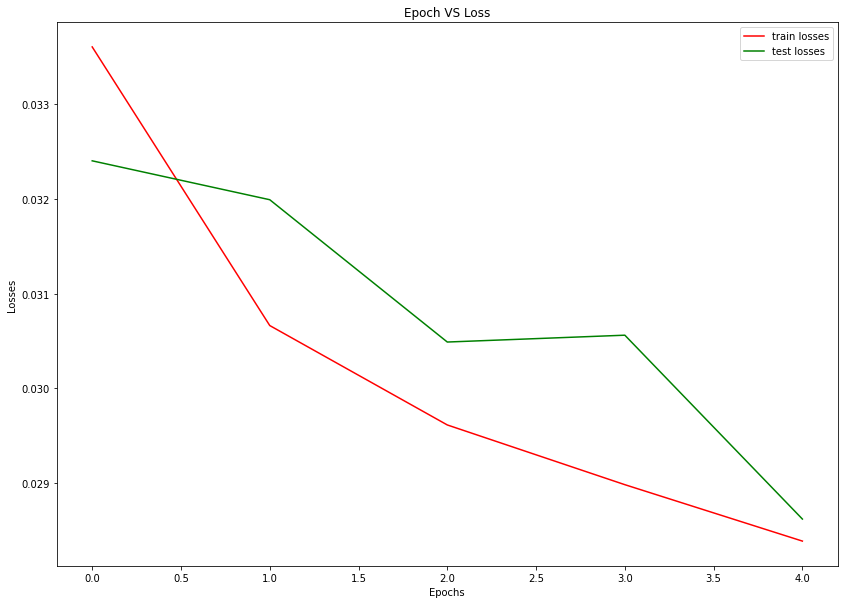

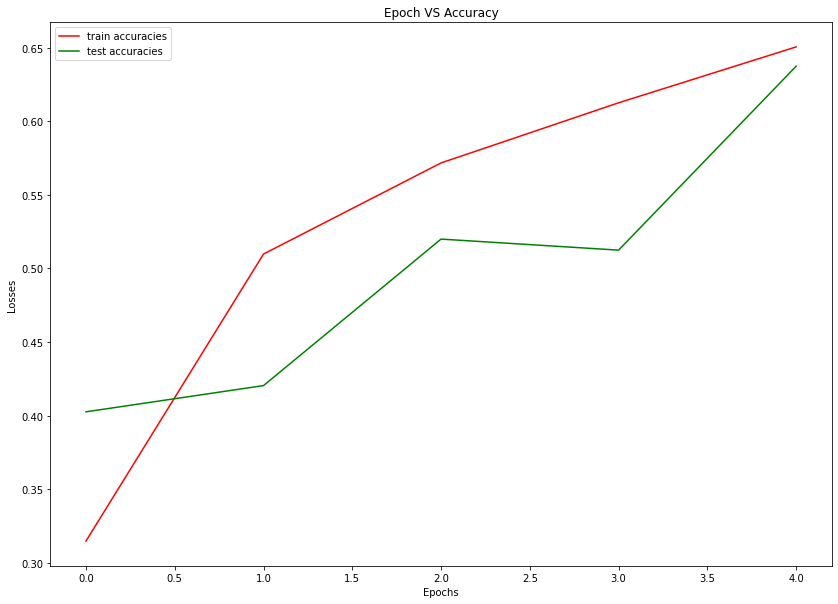

In [ ]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm


def train(model, criterion, optimizer, scheduler, dataloader, device):
  model.train()
  train_loss = 0
  total = 0
  correct = 0

  for image, label in dataloader:
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)

    train_loss += loss.item()
    total += label.size(0)

    pred = torch.max(output.data, 1)[1]
    correct += (pred == label).sum().item()

    loss.backward()
    optimizer.step()
    scheduler.step()

  accuracy = correct/total

  return train_loss/total, accuracy

def test(model, criterion, dataloader, device):
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        
        pred = model(images)
        loss = criterion(pred, labels)
        test_loss += loss.item()
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

  accuracy = correct / total
  return test_loss/total, accuracy

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]))


train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MiniGoogLeNet(10, 3)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=10000, gamma=0.85)
epochs = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for i in tqdm(range(epochs)):
  train_loss, train_accuracy = train(model, criterion, optimizer, scheduler, train_loader, device)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  val_loss, val_accuracy = test(model, criterion, test_loader, device)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

plt.figure(figsize=(14, 10))
plt.plot(range(epochs), train_losses, c='r', label='train losses')
plt.plot(range(epochs), val_losses, c='g', label='test losses')
plt.title("Epoch VS Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

plt.figure(figsize=(14, 10))
plt.plot(range(epochs), train_accuracies, c='r', label='train accuracies')
plt.plot(range(epochs), val_accuracies, c='g', label='test accuracies')
plt.title("Epoch VS Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

